## Inception Recurrent Convolutional Neural Network (IRCNN)

In [1]:
import tensorflow as tf

2022-12-06 00:13:58.298964: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import numpy as np
import cv2
import os
import warnings

from tensorflow.keras.layers import MaxPooling2D, Convolution2D, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Add
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt

In [ ]:
image_size = 512
dropout_rate = 0.2
bs = 16
no_classes = 3

#### Defining the model

In [3]:
# Convolution 2D with batch norm
def conv2d_bn(x, nb_filter, num_row, num_col,
            padding='same', strides=(1, 1), use_bias=False):
  """
  Utility function to apply conv + BN. 
  (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
  """
  if K.image_data_format() == 'channels_first':
    channel_axis = 1
  else:
    channel_axis = -1
  x = Convolution2D(nb_filter, (num_row, num_col),
                    strides=strides,
                    padding=padding,
                    use_bias=use_bias,
                    kernel_regularizer=regularizers.l2(0.00004),
                    kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
  x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
  x = Activation('relu')(x)
  return x

# Recurrent convolutional layer
def RCL(input, kernel_size, filedepth):
  if K.image_data_format() == 'channels_first':
    channel_axis = 1
  else:
    channel_axis = -1

  conv1 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(input)

  stack2 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(conv1)
  stack2 = Activation('relu')(stack2)

  RCL = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same', 
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))

  conv2 = RCL(stack2)
  stack3 = Add()([conv1, conv2])
  stack4 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack3)
  stack4 = Activation('relu')(stack4)


  conv3 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
                 weights=RCL.get_weights(),
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(stack4)
  stack5 = Add()([conv1, conv3])
  stack6 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack5)
  stack6 = Activation('relu')(stack6)


  conv4 = Convolution2D(filters=filedepth, kernel_size=kernel_size, strides=(1, 1), padding='same',
                 weights=RCL.get_weights(),
                 kernel_regularizer=regularizers.l2(0.00004),
                 kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(stack6)
  stack7 = Add()([conv1, conv4])
  stack8 = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(stack7)
  stack8 = Activation('relu')(stack8)

  return stack8


def IRCNN_block(input):
  if K.image_data_format() == 'channels_first':
    channel_axis = 1
  else:
    channel_axis = -1

  branch_0 = RCL(input, (1, 1), 64)

  branch_1 = RCL(input, (3, 3), 128)

  branch_2 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
  branch_2 = RCL(branch_2, (1, 1), 64)

  x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
  return x

Below we have used 3 IRCNN blocks with transitional layers as per the paper.

In [4]:
def IRCNN_base(input):

  if K.image_data_format() == 'channels_first':
    inputShape = (3, 256, 256)
    channel_axis = 1
  else:
    inputShape = (256, 256, 3)
    channel_axis = -1

  # Input Shape is 3 x 256 x 256
  net = Convolution2D(32, (3, 3), strides=(2,2), padding='valid')(input)
  net = conv2d_bn(net, 32, 3, 3, padding='valid')
  net = conv2d_bn(net, 64, 3, 3)

  net = IRCNN_block(input)
                 
  net = conv2d_bn(net, 32, 3, 3, strides=(2,2), padding='valid')
  net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
  net = Dropout(0.5)(net)

  net = IRCNN_block(input)
                 
  net = conv2d_bn(net, 32, 3, 3, strides=(2,2), padding='valid')
  net = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)
  net = Dropout(0.5)(net)
                 
  net = IRCNN_block(input)
                 
  net = conv2d_bn(net, 32, 3, 3, strides=(2,2), padding='valid')
  net = GlobalAveragePooling2D()(net)
  net = Dropout(0.5)(net)
  
  
  return net			

In [13]:
if K.image_data_format() == 'channels_first':
  inputs = Input(shape = (3, image_size, image_size))
else:
  inputs = Input(shape = (image_size, image_size, 3))

x = Convolution2D(32, (3, 3), strides=(2,2), padding='valid')(inputs)
x = IRCNN_base(x)
x = Dense(units=no_classes, activation='softmax')(x)

model = Model(inputs, x, name='IRCNN')

2022-12-06 00:13:59.280987: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 00:13:59.281872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-06 00:13:59.316398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro P5000 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 269.00GiB/s
2022-12-06 00:13:59.316440: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-06 00:13:59.319475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-06 00:13:59.319573: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-12

## Model Summary 

In [14]:
model.summary()

Model: "IRCNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_2 (AveragePoo (None, 255, 255, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 255, 255, 64) 2112        conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [15]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

workspace_path = '/home/ahmedf/Downloads/segmented_images_classified/'
weights_path = workspace_path + 'weights_adam.hdf5' # "weights-{epoch:02d}-{val_acc:.2f}.hdf5"

mcp = callbacks.ModelCheckpoint(weights_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max', save_freq=100)
callbacks_list = [mcp]

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=["accuracy"])

Load the dataset

In [ ]:
train_path = '/home/ahmedf/Downloads/segmented_images_classified/'

In [16]:
aug = ImageDataGenerator(rotation_range=45,
                         fill_mode='wrap',
                         samplewise_center=True,
                         samplewise_std_normalization=True,
                         horizontal_flip=True, 
                         vertical_flip=True, 
                         validation_split=0.15)


train_generator = aug.flow_from_directory(
    train_path,
    target_size=(image_size, image_size), #256,256
    batch_size=bs,
    subset='training') # set as training data

validation_generator = aug.flow_from_directory(
    train_path, # same directory as training data
    target_size=(image_size, image_size),#256,256
    batch_size=bs,
    subset='validation') # set as validation data

Found 1530 images belonging to 3 classes.
Found 270 images belonging to 3 classes.


In [17]:
train_step=train_generator.n//train_generator.batch_size
valid_step=validation_generator.n//validation_generator.batch_size

# Check point saver:

In [19]:
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/

/bin/bash: /home/ahmedf/anaconda3/envs/skin_deep/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)


Training...

In [20]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_step,
        validation_data=validation_generator,
        validation_steps=valid_step,
        epochs=75,
        callbacks=callbacks_list,
        verbose=1,
        shuffle=True)
    
training_checkpoints_path = '/home/ahmedf/Downloads/training_checkpoints'
checkpoint = tf.train.Checkpoint(model)
save_path = checkpoint.save(training_checkpoints_path)
save_path
    # make lr=0.001 after 20 epochs

/home/ahmedf/anaconda3/envs/skin_deep/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-12-06 00:14:06.459739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-06 00:14:06.482204: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/75


2022-12-06 00:14:07.473023: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-06 00:14:08.572841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


95/95 [==============================] - 128s 1s/step - loss: 1.0456 - accuracy: 0.5382 - val_loss: 3.1582 - val_accuracy: 0.1758
Epoch 2/75
95/95 [==============================] - 120s 1s/step - loss: 0.9175 - accuracy: 0.6840 - val_loss: 3.7271 - val_accuracy: 0.7109
Epoch 3/75
95/95 [==============================] - 118s 1s/step - loss: 0.9194 - accuracy: 0.6949 - val_loss: 3.6183 - val_accuracy: 0.6992
Epoch 4/75
95/95 [==============================] - 121s 1s/step - loss: 0.8850 - accuracy: 0.7062 - val_loss: 4.0075 - val_accuracy: 0.7148
Epoch 5/75
95/95 [==============================] - 122s 1s/step - loss: 0.8588 - accuracy: 0.7049 - val_loss: 2.4418 - val_accuracy: 0.7188
Epoch 6/75
95/95 [==============================] - 119s 1s/step - loss: 0.8560 - accuracy: 0.7208 - val_loss: 2.8485 - val_accuracy: 0.7148
Epoch 7/75
95/95 [==============================] - 121s 1s/step - loss: 0.8631 - accuracy: 0.7062 - val_loss: 3.3567 - val_accuracy: 0.7109
Epoch 8/75
95/95 [======

95/95 [==============================] - 122s 1s/step - loss: 0.8261 - accuracy: 0.6920 - val_loss: 0.8074 - val_accuracy: 0.7031
Epoch 30/75
95/95 [==============================] - 122s 1s/step - loss: 0.8245 - accuracy: 0.7023 - val_loss: 0.9782 - val_accuracy: 0.7070
Epoch 31/75
95/95 [==============================] - 121s 1s/step - loss: 0.7789 - accuracy: 0.7305 - val_loss: 0.8020 - val_accuracy: 0.7148
Epoch 32/75
95/95 [==============================] - 120s 1s/step - loss: 0.8185 - accuracy: 0.7035 - val_loss: 1.2490 - val_accuracy: 0.7109
Epoch 33/75
95/95 [==============================] - 123s 1s/step - loss: 0.7999 - accuracy: 0.7214 - val_loss: 0.9594 - val_accuracy: 0.7148
Epoch 34/75
95/95 [==============================] - 122s 1s/step - loss: 0.8270 - accuracy: 0.6844 - val_loss: 0.8728 - val_accuracy: 0.7070
Epoch 35/75
95/95 [==============================] - 123s 1s/step - loss: 0.8324 - accuracy: 0.6986 - val_loss: 0.8137 - val_accuracy: 0.7109
Epoch 36/75
95/95 

95/95 [==============================] - 120s 1s/step - loss: 0.8315 - accuracy: 0.6993 - val_loss: 0.7963 - val_accuracy: 0.7070
Epoch 57/75
95/95 [==============================] - 121s 1s/step - loss: 0.7823 - accuracy: 0.7048 - val_loss: 0.7800 - val_accuracy: 0.7188
Epoch 58/75
95/95 [==============================] - 122s 1s/step - loss: 0.7781 - accuracy: 0.7152 - val_loss: 0.7917 - val_accuracy: 0.7188
Epoch 59/75
95/95 [==============================] - 120s 1s/step - loss: 0.8243 - accuracy: 0.6844 - val_loss: 0.8058 - val_accuracy: 0.7109
Epoch 60/75
95/95 [==============================] - 120s 1s/step - loss: 0.7597 - accuracy: 0.7275 - val_loss: 0.7900 - val_accuracy: 0.7148
Epoch 61/75
95/95 [==============================] - 123s 1s/step - loss: 0.8242 - accuracy: 0.6934 - val_loss: 0.8144 - val_accuracy: 0.7109
Epoch 62/75
95/95 [==============================] - 120s 1s/step - loss: 0.8225 - accuracy: 0.6991 - val_loss: 1.1048 - val_accuracy: 0.7188
Epoch 63/75
95/95 

'/home/ahmedf/Downloads/training_checkpoints-1'

Text(0.5, 1.0, 'Accuracy of IRCNN')

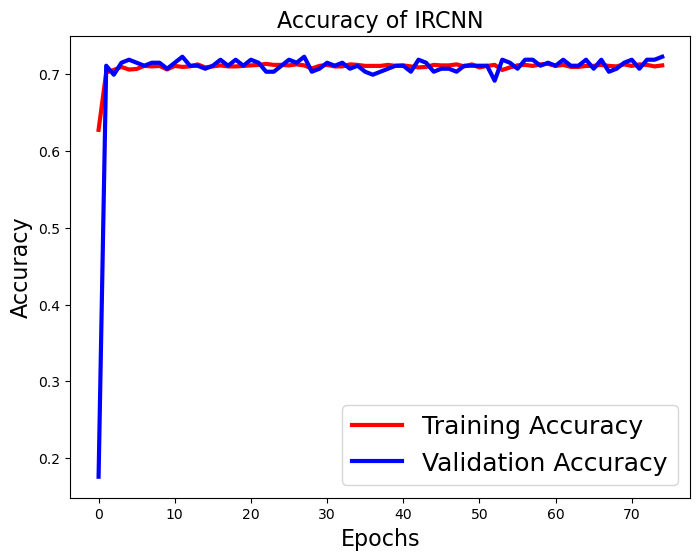

In [26]:
fig = plt.figure(figsize=[8, 6])
results_type = 'Accuracy'
model_name = 'IRCNN'
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type + ' of ' + model_name, fontsize=16)

Text(0.5, 1.0, 'Loss of IRCNN')

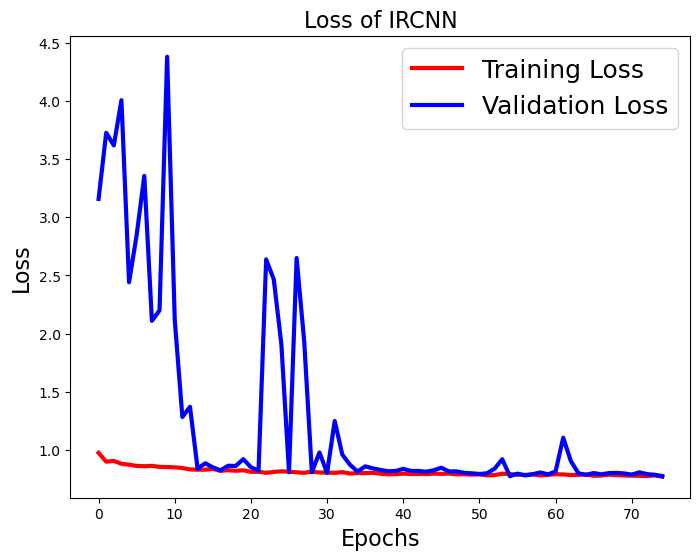

In [27]:
fig = plt.figure(figsize=[8, 6])
results_type = 'Loss'
model_name = 'IRCNN'
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training ' + results_type, 'Validation ' + results_type], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel(results_type, fontsize=16)
plt.title(results_type + ' of ' + model_name, fontsize=16)

### Restoring the latest checkpoint in checkpoint_dir

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(training_checkpoints_path))

#### Model Evaluation

In [44]:
print(validation_generator.class_indices)

{'mel': 0, 'nev': 1, 'sk': 2}


In [77]:
class_map = {0: 'mel', 1:'nev', 2: 'sk'}

In [84]:
prediction = model(validation_generator[0][0], training=True)
for ind in range(prediction.shape[0]):
    pr_class = class_map[np.argsort(prediction[ind].numpy())[::-1][:1][0]]
    gt_class = class_map[np.argsort(validation_generator[0][1][ind])[::-1][:1][0]]
    res = (pr_class == gt_class)
    print("Ground truth: {0} - Prediction: {1} -  Is_Correct: {2}\n".format(gt_class, pr_class, res))

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: mel - Prediction: nev -  Is_Correct: False

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: mel - Prediction: nev -  Is_Correct: False

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: sk - Prediction: nev -  Is_Correct: False

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: mel - Prediction: nev -  Is_Correct: False

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: sk - Prediction: nev -  Is_Correct: False

Ground truth: nev - Prediction: nev -  Is_Correct: True

Ground truth: mel - Prediction: nev -  Is_Correct: False

Ground truth: sk - Prediction: nev -  Is_Correct: False



In [85]:
preds = model.evaluate(validation_generator, batch_size=bs, verbose=1, sample_weight=None)

17/17 [==============================] - 14s 826ms/step - loss: 0.7952 - accuracy: 0.7111
